# Multimodal Training Pipeline Tutorial
---

## Step 1: Import Libraries

Import all needed libraries, custom functionality and models. When a package is not found use:

`pip install "package"`

In [1]:
import pandas as pd
import numpy as np
import torch

# Add src to path
import sys
sys.path.append('../src')

from preprocess.preprocess import partition_data,load_config, preprocess_data
from preprocess.data_loader import prepare_chemical_data, prepare_transcriptomics_data
from sklearn.preprocessing import StandardScaler
from preprocess.molecule_graph import mol_to_graph

from sklearn.model_selection import train_test_split
from models.gnn import GNN
from models.multimodal_nn import MultimodalNN
from models.transcriptomics_nn import TranscriptomicsNN
from training.train_multimodal import train_multimodal_model

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from utils.evaluation import evaluate_regression_metrics

import torch
from models.unimodal import CNN, FFNN
from training.train_unimodal import train_unimodal_model, evaluate_unimodal_model
from visualizations.visualizations import (
    create_visualizations,
    plot_loss_curves,
    plot_predictions_combined,
    plot_residuals_combined,
    plot_error_boxplots,
)

from training.train_shallow import evaluate_shallow_model

2024-11-26 10:24:35,353 - INFO - Enabling RDKit 2024.03.6 jupyter extensions
2024-11-26 10:24:40,792 - INFO - TensorFlow version 2.13.0 available.
2024-11-26 10:24:40,793 - INFO - PyTorch version 2.0.1+cpu available.
2024-11-26 10:24:40,909 - INFO - Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


## Step 2: Preprocess Data

In this step the data is processed from the raw .tsv/.csv files of chemical compounds, transcriptomic TF data and the viability target. The data is located in the `data/raw` folder:
- `compoundinfo.csv`: Chemical compounds with their SMILES representation and an unique ID for each pertubation compound.
- `X.tsv`: Unique pertubation experiments per row with their corresponding changes in TF gene expression.
- `Y.tsv`: Pertubation experiment outcomes linking a cell line with an unqiue pertubation compound and its concentration with their viability score as experiment outcome.

All the preprocessing is encapsulated in the hih level `preprocess_data` function that does the following in consecutive order:
1. Load the 3 raw data tables from their paths specified in the `config.yaml` file (This allows for easier adaptation and best MLOps practices)
2. The tables are merged by a table join on the compound ID and cell line experiment ID. This results in a single `pd.Dataframe` that has on each row the compound information, the TF gene expression data and the viability score.
3. The resulting `pd.Dataframe` is evaluated on missing values, when present the complete row is removed. If it turns out that a lot of rows are removed, data imputation might be a better option.
4. TF gene expression data is standardized to have zero mean and a standard deviation of 1 to stabilize training in later steps.
5. The merged and processed data is then saved to `data/processed` as `final_dataset.csv`.       

In [2]:
# config = load_config("../config.yaml")
# preprocess_data(config)

Afterwards, we can simply load in this merged dataset using Pandas. We select the first 1000 rows of the 30.000 for faster code execution.

In [3]:
combined_df = pd.read_csv("../data/processed/final_dataset.csv")

# Only select the first 1000 rows for easy handling
combined_df = combined_df.iloc[:1000]

Then we split the data into training testing and validation sets. This allows for hyperparameter tuning and model evaluation in later steps.

In [4]:
# Split the data into training, validation, and test sets
train_size = 0.7
val_size = 0.15
test_size = 0.15

# First split into train and temp (val + test)
train_indices, temp_indices = train_test_split(
    combined_df.index, train_size=train_size, random_state=42
)

# Then split temp into validation and test
val_indices, test_indices = train_test_split(
    temp_indices, test_size=test_size / (test_size + val_size), random_state=42
)

# Create dataframes for each split
train_df = combined_df.loc[train_indices]
val_df = combined_df.loc[val_indices]
test_df = combined_df.loc[test_indices]

# Partition each split
train_chem_df, train_viability_df, train_transcriptomics_df = partition_data(train_df)
val_chem_df, val_viability_df, val_transcriptomics_df = partition_data(val_df)
test_chem_df, test_viability_df, test_transcriptomics_df = partition_data(test_df)

# Validate the shapes of the dataframes
print(train_chem_df.shape, train_viability_df.shape, train_transcriptomics_df.shape)

(700, 1) (700, 1) (700, 682)


In [5]:
# Prepare chemical data loaders
train_chem_loader = prepare_chemical_data(
    train_chem_df["canonical_smiles"].tolist(),
    train_viability_df["viability"].tolist(),
    batch_size=32,
)
val_chem_loader = prepare_chemical_data(
    val_chem_df["canonical_smiles"].tolist(),
    val_viability_df["viability"].tolist(),
    batch_size=32,
)
test_chem_loader = prepare_chemical_data(
    test_chem_df["canonical_smiles"].tolist(),
    test_viability_df["viability"].tolist(),
    batch_size=32,
)

# Prepare transcriptomics data loaders
train_trans_loader = prepare_transcriptomics_data(
    train_transcriptomics_df, train_viability_df["viability"].tolist(), batch_size=32
)
val_trans_loader = prepare_transcriptomics_data(
    val_transcriptomics_df, val_viability_df["viability"].tolist(), batch_size=32
)
test_trans_loader = prepare_transcriptomics_data(
    test_transcriptomics_df, test_viability_df["viability"].tolist(), batch_size=32
)

Processed 700 valid graphs out of 700 SMILES
Processed 150 valid graphs out of 150 SMILES
Processed 150 valid graphs out of 150 SMILES


## Step 3: Benchmarking on Unimodal Information

Before approaching multimodal learning, we need to test wheter or not it is even needed. In other words, how accurate can we predict the viability score from the TF gene epxression alone? Additionally, how complex is this learning task? Therefore, we will first train and evaluate simple (shallow and/or linear) models to set a benchmark for later deep and multimodal models.

### 3.1 Simple ML Models for Regression

Training and Evaluating Linear Regression...
Training and Evaluating Ridge Regression...
Training and Evaluating Lasso Regression...
Training and Evaluating Random Forest Regressor...
Training and Evaluating Gradient Boosting Regressor...
                             Test Loss       MSE       MAE         R²  \
Linear Regression             1.084772  1.084772  0.820436 -12.165462   
Ridge Regression              0.143337  0.143337  0.301067  -0.739620   
Lasso Regression              0.039927  0.039927  0.154216   0.515416   
Random Forest Regressor       0.043612  0.043612  0.153073   0.470703   
Gradient Boosting Regressor   0.036542  0.036542  0.142580   0.556505   

                             Pearson Correlation  
Linear Regression                       0.143486  
Ridge Regression                        0.414418  
Lasso Regression                        0.717925  
Random Forest Regressor                 0.688582  
Gradient Boosting Regressor             0.747362  
Generating resid

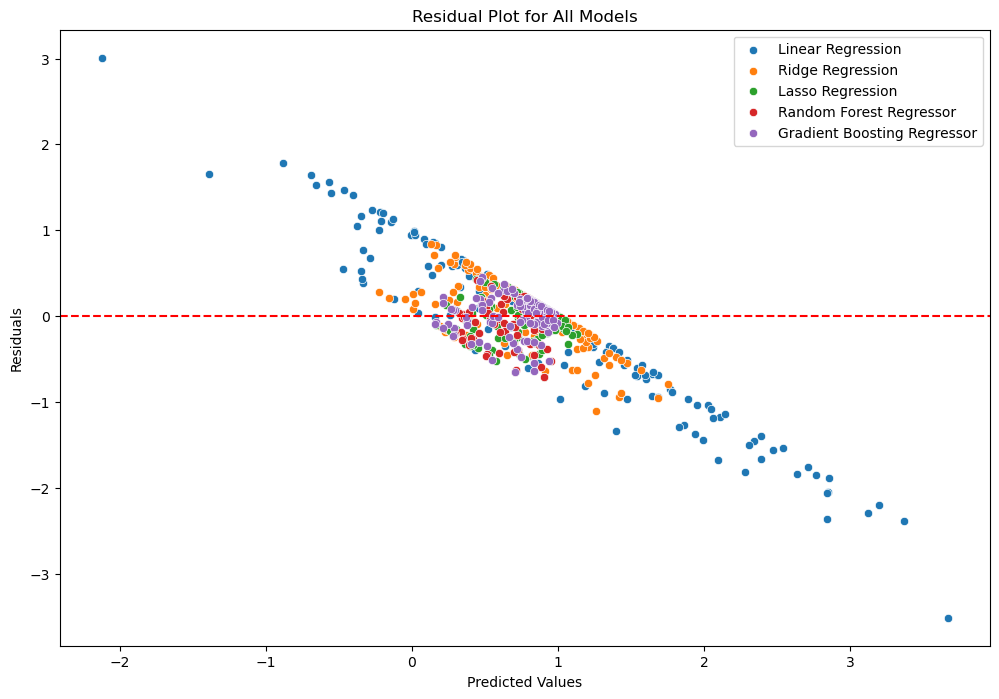

Generating prediction plots...


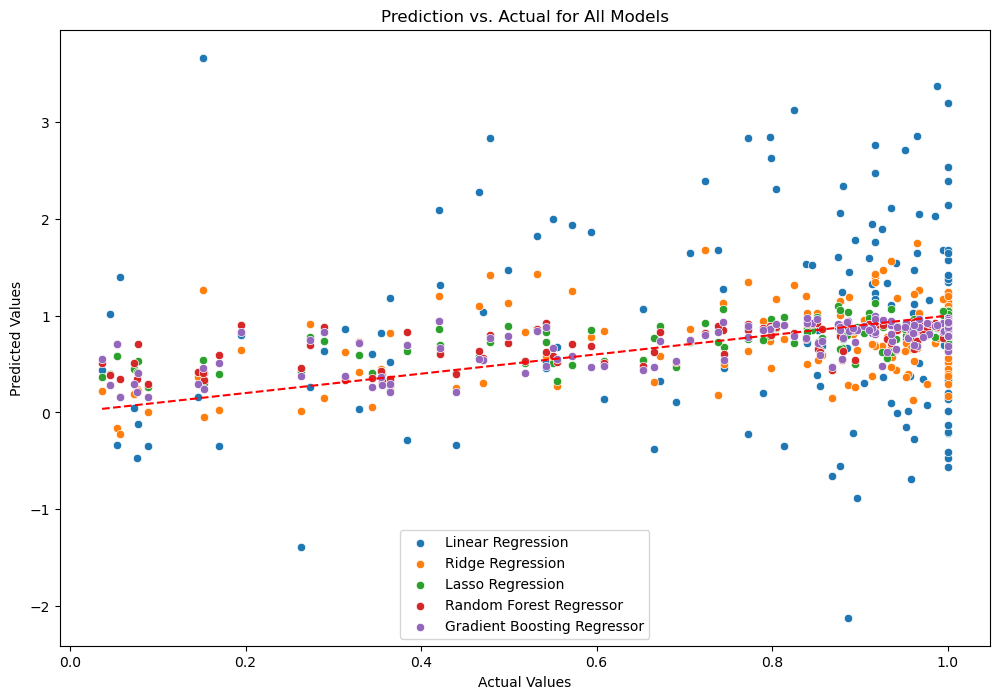

Generating error boxplots...


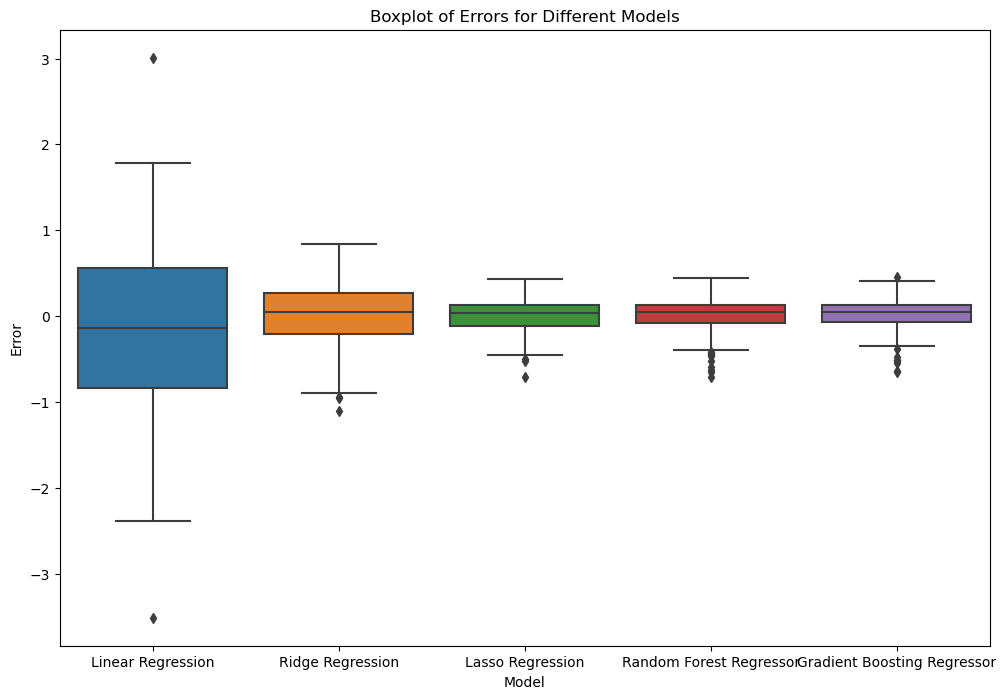

In [6]:
# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(alpha=0.01),
    "Random Forest Regressor": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
}

# Prepare data
X_train = train_transcriptomics_df.values
y_train = train_viability_df["viability"].values
X_val = val_transcriptomics_df.values
y_val = val_viability_df["viability"].values
X_test = test_transcriptomics_df.values
y_test = test_viability_df["viability"].values

# Initialize results dictionary
results = {}

# Train, evaluate, and collect results
for name, model in models.items():
    print(f"Training and Evaluating {name}...")

    # Fit the model on training data
    model.fit(X_train, y_train)

    # Evaluate the model
    test_loss, y_true, y_pred, metrics = evaluate_shallow_model(
        model, X_test, y_test, calculate_metrics=True
    )

    # Store evaluation results
    results[name] = {
        "Test Loss": test_loss,
        "MSE": metrics["MSE"],
        "MAE": metrics["MAE"],
        "R²": metrics["R²"],
        "Pearson Correlation": metrics["Pearson Correlation"],
    }

# Display results in a DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

# Generate visualizations
create_visualizations(models=models, X_test=X_test, y_test=y_test)

### 3.2: Unimodal Deep Learning Models

Training FFNN...
Epoch 1/50, Train Loss: 0.4897, Val Loss: 0.1301
Epoch 2/50, Train Loss: 0.2857, Val Loss: 0.1196
Epoch 3/50, Train Loss: 0.2507, Val Loss: 0.0869
Epoch 4/50, Train Loss: 0.2158, Val Loss: 0.1049
Epoch 5/50, Train Loss: 0.1827, Val Loss: 0.0821
Epoch 6/50, Train Loss: 0.1725, Val Loss: 0.0736
Epoch 7/50, Train Loss: 0.1530, Val Loss: 0.0681
Epoch 8/50, Train Loss: 0.1183, Val Loss: 0.0662
Epoch 9/50, Train Loss: 0.1075, Val Loss: 0.0554
Epoch 10/50, Train Loss: 0.0850, Val Loss: 0.0541
Epoch 11/50, Train Loss: 0.0659, Val Loss: 0.0422
Epoch 12/50, Train Loss: 0.0557, Val Loss: 0.0507
Epoch 13/50, Train Loss: 0.0499, Val Loss: 0.0501
Epoch 14/50, Train Loss: 0.0486, Val Loss: 0.0423
Epoch 15/50, Train Loss: 0.0440, Val Loss: 0.0409
Epoch 16/50, Train Loss: 0.0323, Val Loss: 0.0414
Epoch 17/50, Train Loss: 0.0351, Val Loss: 0.0471
Epoch 18/50, Train Loss: 0.0329, Val Loss: 0.0383
Epoch 19/50, Train Loss: 0.0267, Val Loss: 0.0367
Epoch 20/50, Train Loss: 0.0228, Val Loss:

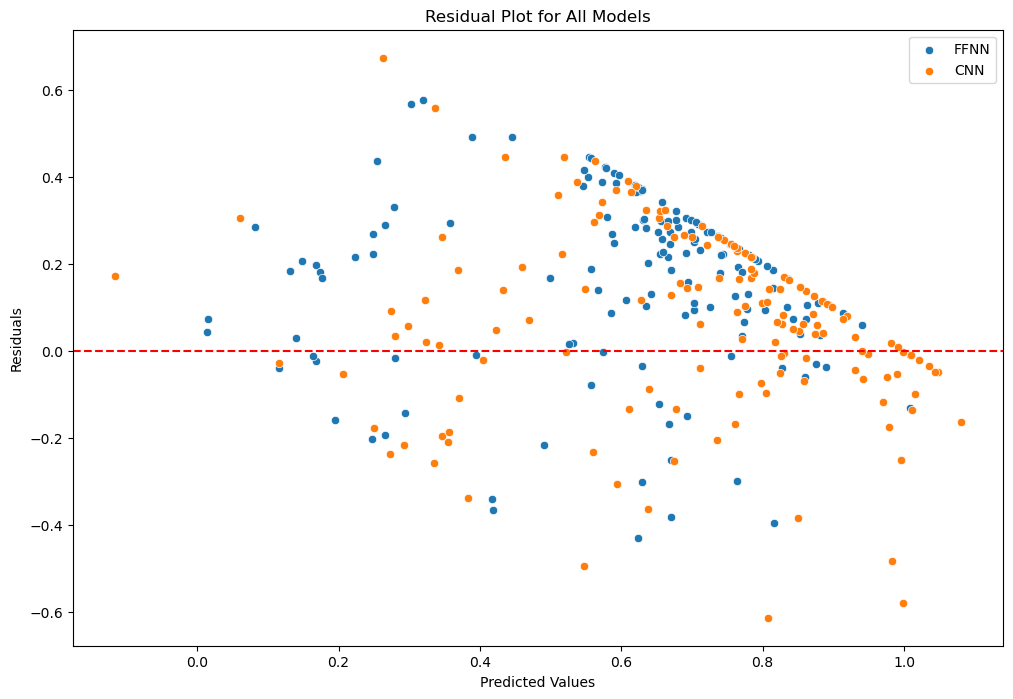

Generating prediction plots...


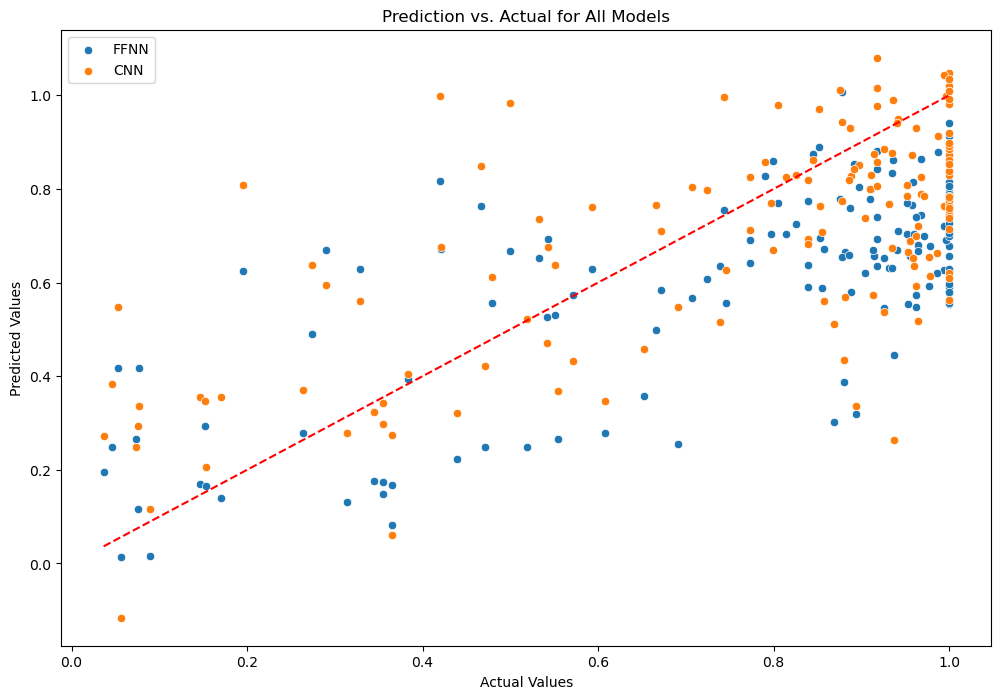

Generating error boxplots...


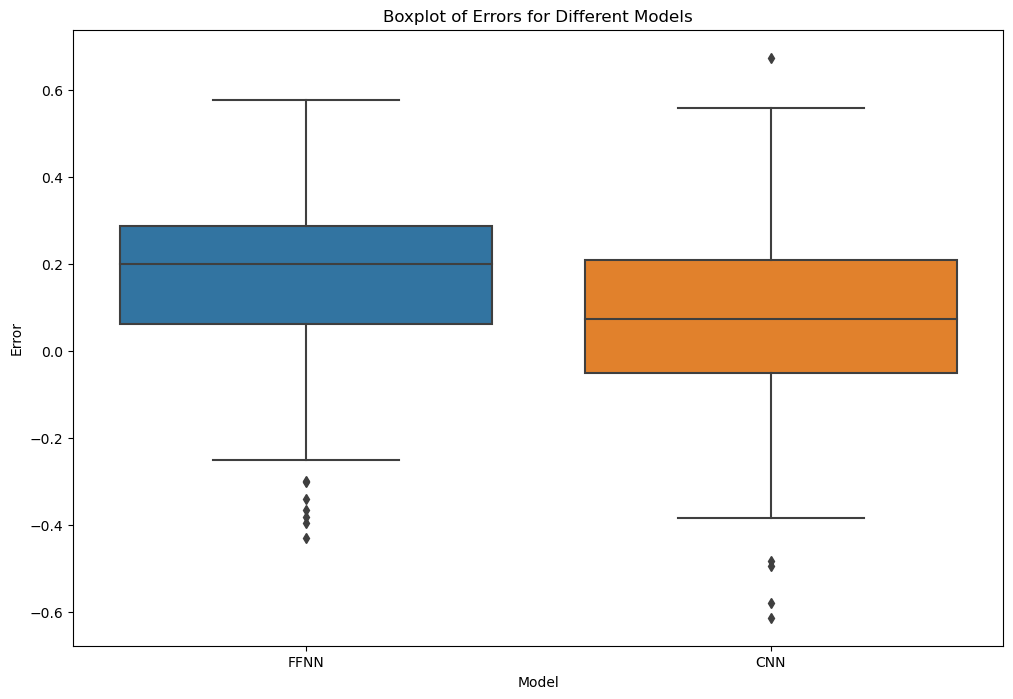

Generating loss curves...


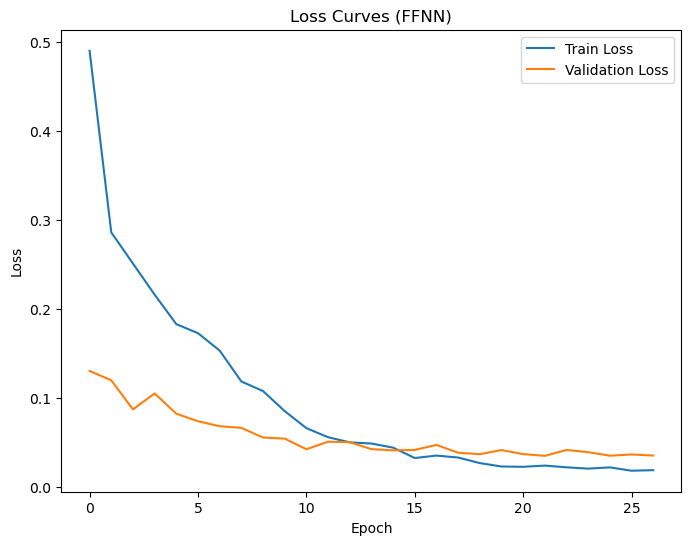

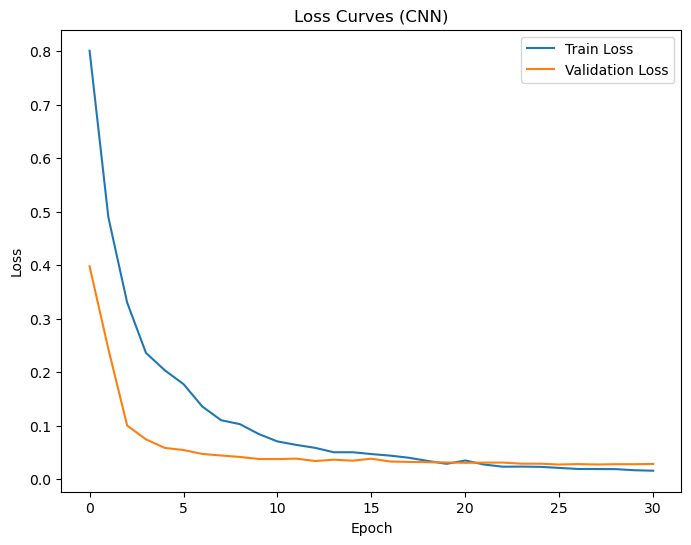

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define models
ffnn = FFNN(input_dim=X_train.shape[1], hidden_dim=128, output_dim=1)
cnn = CNN(input_dim=X_train.shape[1], hidden_dim=64, output_dim=1)

# Define loss function and optimizer
criterion = torch.nn.SmoothL1Loss()  # Huber Loss, robust to outliers
ffnn_optimizer = torch.optim.AdamW(ffnn.parameters(), lr=0.001, weight_decay=1e-5)
cnn_optimizer = torch.optim.AdamW(cnn.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate schedulers
ffnn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    ffnn_optimizer, mode="min", patience=3, factor=0.5
)
cnn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    cnn_optimizer, mode="min", patience=3, factor=0.5
)

# Train FFNN
print("Training FFNN...")
ffnn_train_losses, ffnn_val_losses = train_unimodal_model(
    ffnn,
    train_trans_loader,
    val_trans_loader,
    criterion,
    ffnn_optimizer,
    ffnn_scheduler,
    epochs=50,
    device=device,
    gradient_clipping=1.0,  # Prevent exploding gradients
    early_stopping_patience=5,  # Stop early if no improvement
)

# Train CNN
print("Training CNN...")
cnn_train_losses, cnn_val_losses = train_unimodal_model(
    cnn,
    train_trans_loader,
    val_trans_loader,
    criterion,
    cnn_optimizer,
    cnn_scheduler,
    epochs=50,
    device=device,
    gradient_clipping=1.0,
    early_stopping_patience=5,
)

# Evaluate FFNN
print("Evaluating FFNN...")
ffnn_test_loss, ffnn_y_true, ffnn_y_pred, ffnn_metrics = evaluate_unimodal_model(
    ffnn, test_trans_loader, criterion, device, calculate_metrics=True
)
print(
    f"FFNN Test Loss: {ffnn_test_loss:.4f}, "
    f"MSE: {ffnn_metrics['MSE']:.4f}, "
    f"MAE: {ffnn_metrics['MAE']:.4f}, "
    f"R²: {ffnn_metrics['R²']:.4f}, "
    f"Pearson: {ffnn_metrics['Pearson Correlation']:.4f}"
)

# Evaluate CNN
print("Evaluating CNN...")
cnn_test_loss, cnn_y_true, cnn_y_pred, cnn_metrics = evaluate_unimodal_model(
    cnn, test_trans_loader, criterion, device, calculate_metrics=True
)
print(
    f"CNN Test Loss: {cnn_test_loss:.4f}, "
    f"MSE: {cnn_metrics['MSE']:.4f}, "
    f"MAE: {cnn_metrics['MAE']:.4f}, "
    f"R²: {cnn_metrics['R²']:.4f}, "
    f"Pearson: {cnn_metrics['Pearson Correlation']:.4f}"
)

# Create visualizations
create_visualizations(
    models={"FFNN": ffnn, "CNN": cnn},
    X_test=X_test,
    y_test=y_test,
    train_losses={"FFNN": ffnn_train_losses, "CNN": cnn_train_losses},
    val_losses={"FFNN": ffnn_val_losses, "CNN": cnn_val_losses},
)

## Step 3: Multimodal Model Design

#### Separate Feature Extractors:
We will use separate neural networks to extract latent features from each modality:
- **Chemical Data (SMILES):** We will use Graph Neural Networks (GNNs) to process the SMILES representations of chemical compounds. GNNs are well-suited for capturing the structural as well as the hierarchical data information of molecules.
- **Transcriptomics Data:** We will use autoencoders or other neural network architectures to process the TF gene expression data. These models will help in reducing the dimensionality and extracting meaningful features from the high-dimensional gene expression data.

#### Shared Latent Space:
After extracting features from each modality, we will map them to a shared latent space with aligned dimensionality. This shared latent space will allow us to jointly optimize the feature extraction process and the downstream predictive tasks. By aligning the dimensionality, we ensure that the features from different modalities can be effectively combined and compared.

#### Fusion Strategies:
We will explore different fusion strategies to integrate the latent features from each modality:
- **Intermediate Fusion:** In this strategy, we will first learn latent features independently for each modality. Then, we will integrate these features through concatenation or attention layers. This approach allows us to capture the unique characteristics of each modality before combining them for the final prediction.

By following this multimodal approach, we aim to harness the strengths of both chemical and transcriptomics data, leading to more accurate and reliable predictions in our downstream tasks.

![Multimodal schema](https://blog.roboflow.com/content/images/2024/04/image-1203.webp)

In [8]:



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Load data
# final_df = pd.read_csv("data/processed/final_dataset.csv")
# chem_df, viability_df, transcriptomics_df = partition_data(final_df)

# # Prepare chemical data
# smiles_list = chem_df["canonical_smiles"].tolist()
# targets = viability_df["viability"].tolist()
# chem_data_loader = prepare_chemical_data(smiles_list, targets, batch_size=32)

# # Prepare transcriptomics data
# transcriptomics_data_loader = prepare_transcriptomics_data(
#     transcriptomics_df, targets, batch_size=32
# )

# Initialize models
num_node_features = 15
num_edge_features = 13

chem_model = GNN(
    num_node_features=num_node_features,
    num_edge_features=num_edge_features,
    hidden_dim=64,
    output_dim=128,
    dropout=0.1,  # If applicable
).to(device)

trans_model = TranscriptomicsNN(
    input_dim=transcriptomics_df.shape[1],
    hidden_dim=512,
    output_dim=128,
    dropout=0.1,  # If applicable
).to(device)

multimodal_model = MultimodalNN(
    chem_output_dim=128,
    trans_output_dim=128,
    hidden_dim=256,
    output_dim=1,
    dropout=0.1,  # If applicable
).to(device)

# Initialize optimizer and loss function
optimizer = torch.optim.Adam(
    list(chem_model.parameters())
    + list(trans_model.parameters())
    + list(multimodal_model.parameters()),
    lr=0.001,
)
criterion = torch.nn.MSELoss()

print("Start training the models!")

# Train the model
train_multimodal_model(
    chem_model,
    trans_model,
    multimodal_model,
    chem_data_loader,
    transcriptomics_data_loader,
    optimizer,
    criterion,
    device,
    epochs=10,
)

NameError: name 'transcriptomics_df' is not defined

In [ ]:
# Read in the .tsv data file that is seperated by tabs
XX = pd.read_csv("../data/raw/X.tsv", sep="\t")

In [ ]:
# Check the number of rows and columns of the loaded data
print(XX.shape)